# NoteBook - Test 1


Instalar dependencias y requirements.txt


In [1]:
import sys, subprocess, pathlib

# Ruta al requirements desde el notebook
root = pathlib.Path("..").resolve()
req  = root / "requirements.txt"

# Instala usando el mismo intérprete del kernel
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", str(req)])
print("✅ Dependencias instaladas")


✅ Dependencias instaladas


Preparar imports del proyecto


In [2]:
import sys, pathlib
root = pathlib.Path("..").resolve()          # carpeta Capgemini
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
print(root)

C:\Users\Javichu\OneDrive - UFV\Escritorio\personal\Capgemini\Capgemini


Smoke Test de los paquetes


In [3]:
import importlib
mod = importlib.import_module("src.telco_churn")
print("✅ src.telco_churn importado:", mod)


✅ src.telco_churn importado: <module 'src.telco_churn' from 'C:\\Users\\Javichu\\OneDrive - UFV\\Escritorio\\personal\\Capgemini\\Capgemini\\src\\telco_churn\\__init__.py'>


Comprobar Ml Flow


In [4]:
from pathlib import Path
import mlflow

# root debe apuntar a la carpeta del proyecto (si vienes de la Celda B, ya lo tienes)
mlruns_dir = (root / "mlruns").resolve()
mlruns_dir.mkdir(parents=True, exist_ok=True)  # por si no existe

mlflow.set_tracking_uri(mlruns_dir.as_uri())   # <-- genera "file:///C:/...”
mlflow.set_experiment("telco_churn_experiment")
print("✅ MLflow configurado en:", mlflow.get_tracking_uri())


✅ MLflow configurado en: file:///C:/Users/Javichu/OneDrive%20-%20UFV/Escritorio/personal/Capgemini/Capgemini/mlruns


Localización el CSV


In [5]:
from pathlib import Path

RAW = Path("../data/raw")
CSV = RAW / "WA_Fn-UseC_-Telco-Customer-Churn.csv"

if not CSV.exists():
    raise FileNotFoundError(
        f"⚠️ No encuentro {CSV}.\n"
        "Descárgalo desde Kaggle (web) y colócalo en data/raw/ con ese nombre."
    )
CSV


WindowsPath('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Carga + Limpieza minima (tipos y valores)

In [6]:
import pandas as pd
import numpy as np
import importlib

mod = importlib.import_module("src.telco_churn")

df = pd.read_csv(CSV)

# Limpiezas conocidas
df = df.drop(columns=["customerID"], errors="ignore")  # identificador
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Mapear objetivo a 0/1
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# Unificar "No internet/phone service" -> "No" en binarias
for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]:
    if c in df.columns:
        df[c] = df[c].replace({"No internet service": "No"})
if "MultipleLines" in df.columns:
    df["MultipleLines"] = df["MultipleLines"].replace({"No phone service":"No"})

# Coerción suave a numérico donde procede
for c in ["tenure","MonthlyCharges","TotalCharges","SeniorCitizen"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.head(3), df.shape


(   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  Female              0     Yes         No       1           No   
 1    Male              0      No         No      34          Yes   
 2    Male              0      No         No       2          Yes   
 
   MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection  \
 0            No             DSL             No          Yes               No   
 1            No             DSL            Yes           No              Yes   
 2            No             DSL            Yes          Yes               No   
 
   TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
 0          No          No              No  Month-to-month              Yes   
 1          No          No              No        One year               No   
 2          No          No              No  Month-to-month              Yes   
 
       PaymentMethod  MonthlyCharges  TotalCharges  Churn  
 0  Electronic che

Validaciones rapidas (esquema,tipos,nulos, dominios)

In [7]:
from src.telco_churn.evaluate import validate_telco_df
from src.telco_churn.evaluate import pretty_print_report
rep = validate_telco_df(df, strict=False)  # pon strict=True si quieres que pare ante errores
pretty_print_report(rep)


⚠️  WARNINGS:
  - Filas duplicadas: 22


Resumen Rapido(clase,nulos,tipos
)

In [8]:
display(df.dtypes.to_frame("dtype").T)

print("Distribución objetivo (Churn):")
display(df["Churn"].value_counts(normalize=True).rename({0:"No",1:"Yes"}))

print("Top nulos:")
display(df.isna().mean().sort_values(ascending=False).head(10))


gender SeniorCitizen Partner Dependents tenure PhoneService  \
dtype  object         int64  object     object  int64       object   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
dtype        object          object         object       object   

      DeviceProtection TechSupport StreamingTV StreamingMovies Contract  \
dtype           object      object      object          object   object   

      PaperlessBilling PaymentMethod MonthlyCharges TotalCharges  Churn  
dtype           object        object        float64      float64  int32

Distribución objetivo (Churn):


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Top nulos:


TotalCharges        0.001562
gender              0.000000
SeniorCitizen       0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Contract            0.000000
StreamingMovies     0.000000
StreamingTV         0.000000
TechSupport         0.000000
dtype: float64

Guadamos el dataset limpio + muestra

In [9]:
from pathlib import Path

PROCESSED = Path("../data/processed")
PROCESSED.mkdir(parents=True, exist_ok=True)

# Rutas de salida
clean_csv      = PROCESSED / "telco_clean.csv"
sample_csv     = PROCESSED / "telco_sample_5k.csv"
clean_parquet  = PROCESSED / "telco_clean.parquet"
sample_parquet = PROCESSED / "telco_sample_5k.parquet"

# Guardar dataset completo (CSV)
df.to_csv(clean_csv, index=False)

# Crear una muestra (máx. 5k filas) y guardarla (CSV)
sample_df = df.sample(n=min(5000, len(df)), random_state=42)
sample_df.to_csv(sample_csv, index=False)

# Parquet opcional (si tienes pyarrow o fastparquet instalado)
try:
    df.to_parquet(clean_parquet, index=False)
    sample_df.to_parquet(sample_parquet, index=False)
    print("✅ Guardado CSV y Parquet en:", PROCESSED.resolve())
except Exception as e:
    print("✅ Guardado CSV en:", PROCESSED.resolve())
    print("ℹ️ Parquet omitido (instala 'pyarrow' o 'fastparquet' si lo necesitas). Motivo:", e)


✅ Guardado CSV y Parquet en: C:\Users\Javichu\OneDrive - UFV\Escritorio\personal\Capgemini\Capgemini\data\processed


PARTE 3 — Exploratory Data Analysis (EDA)

Paso 1: Cargar y limpiar los datos


In [10]:
from src.telco_churn.data import load_telco_csv
from src.telco_churn.features import basic_cleaning

df = basic_cleaning(load_telco_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv"))
df.shape, df.columns



((7043, 20),
 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
        'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
        'MonthlyCharges', 'TotalCharges', 'Churn'],
       dtype='object'))

Paso 2: Validar Test


In [11]:
from src.telco_churn.evaluate import validate_telco_df, pretty_print_report

report = validate_telco_df(df)
pretty_print_report(report)


⚠️  WARNINGS:
  - Filas duplicadas: 22


Paso 3: Distribucion de la variable Churn



Distribución de clases:


Churn
0    5174
1    1869
Name: count, dtype: int64


Tasa de churn: 26.54%


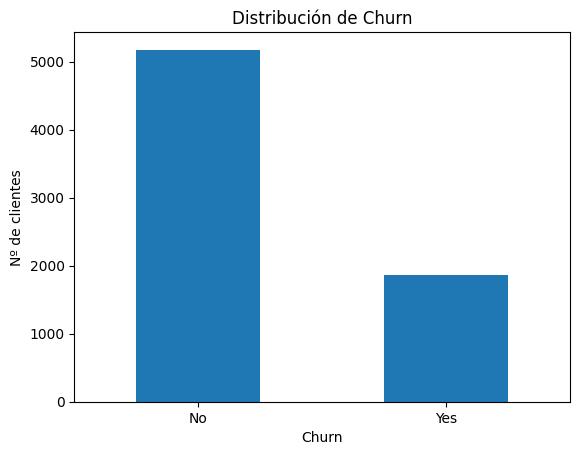

In [12]:
import matplotlib.pyplot as plt

churn_counts = df["Churn"].value_counts()
churn_rate = df["Churn"].mean()

print("Distribución de clases:")
display(churn_counts)
print(f"\nTasa de churn: {churn_rate:.2%}")

churn_counts.plot(kind="bar", title="Distribución de Churn", xlabel="Churn", ylabel="Nº de clientes")
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.show()

Paso 4: Boxplots de variables numericas


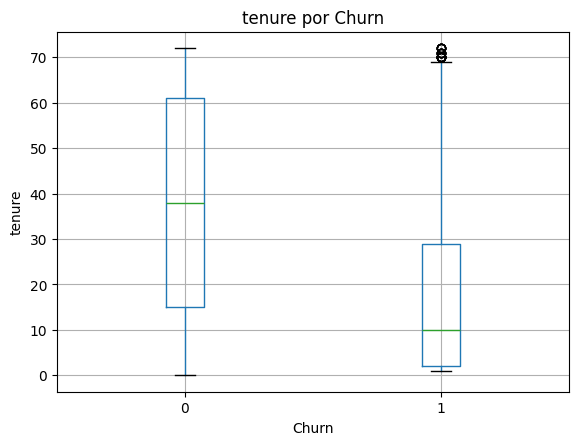

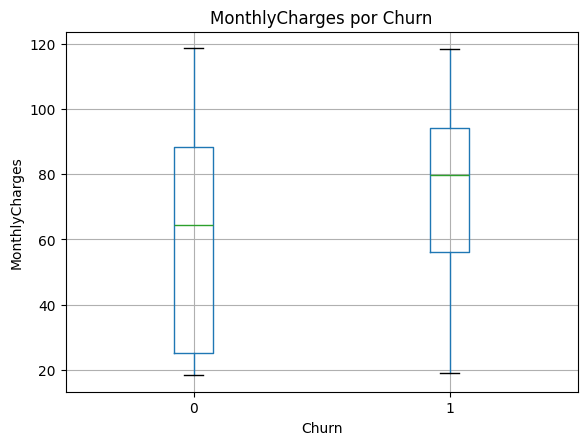

In [13]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in num_cols:
    if col in df.columns:
        df.boxplot(column=col, by="Churn")
        plt.title(f"{col} por Churn")
        plt.suptitle("")
        plt.ylabel(col)
        plt.show()


Paso 5: Tabla resumen numerica por churn


In [14]:
from src.telco_churn.eda import num_summary_by_target

num_summary_by_target(df)


Churn                            0            1
SeniorCitizen  mean       0.128721     0.254682
               median     0.000000     0.000000
               std        0.334923     0.435799
               min        0.000000     0.000000
               max        1.000000     1.000000
tenure         mean      37.569965    17.979133
               median    38.000000    10.000000
               std       24.113777    19.531123
               min        0.000000     1.000000
               max       72.000000    72.000000
MonthlyCharges mean      61.265124    74.441332
               median    64.425000    79.650000
               std       31.092648    24.666053
               min       18.250000    18.850000
               max      118.750000   118.350000
TotalCharges   mean    2555.344141  1531.796094
               median  1683.600000   703.550000
               std     2329.456984  1890.822994
               min       18.800000    18.850000
               max     8672.450000  8684.800000

Paso 6: Matriz de Correlacion (variables numericas)

In [15]:
%pip install seaborn

import seaborn as sns

corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Javichu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Paso 7: Categorías mas relacionadas con churn


In [16]:
from src.telco_churn.eda import churn_rate_table

cat_cols = ["Contract", "InternetService", "PaymentMethod", "TechSupport", "OnlineSecurity"]

for col in cat_cols:
    print(f"\n==== {col} ====")
    display(churn_rate_table(df, col, top=10))



==== Contract ====


rate     n
Contract                      
Month-to-month  0.427097  3875
One year        0.112695  1473
Two year        0.028319  1695


==== InternetService ====


rate     n
InternetService                
Fiber optic      0.418928  3096
DSL              0.189591  2421
No               0.074050  1526


==== PaymentMethod ====


rate     n
PaymentMethod                            
Electronic check           0.452854  2365
Mailed check               0.191067  1612
Bank transfer (automatic)  0.167098  1544
Credit card (automatic)    0.152431  1522


==== TechSupport ====


rate     n
TechSupport                
No           0.311862  4999
Yes          0.151663  2044


==== OnlineSecurity ====


rate     n
OnlineSecurity                
No              0.313296  5024
Yes             0.146112  2019

Paso 8: Analisis de importacia de variables


In [17]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

X = df.drop(columns=["Churn"])
y = df["Churn"]

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

X_enc = preprocessor.fit_transform(X)
feat_names = num_cols + list(preprocessor.named_transformers_["cat"]["ohe"].get_feature_names_out(cat_cols))

mi = mutual_info_classif(X_enc, y, random_state=42)
mi_df = pd.DataFrame({"feature": feat_names, "mutual_info": mi})
mi_df.sort_values("mutual_info", ascending=False).head(15)


feature  mutual_info
29         Contract_Month-to-month     0.101677
1                           tenure     0.063314
31               Contract_Two year     0.056425
2                   MonthlyCharges     0.048263
36  PaymentMethod_Electronic check     0.043864
3                     TotalCharges     0.043082
15     InternetService_Fiber optic     0.035833
16              InternetService_No     0.024882
17               OnlineSecurity_No     0.020798
30               Contract_One year     0.018710
33            PaperlessBilling_Yes     0.018578
32             PaperlessBilling_No     0.017404
18              OnlineSecurity_Yes     0.017387
23                  TechSupport_No     0.016624
9                   Dependents_Yes     0.014006

Paso 9: Posibilidad de Leakage


In [18]:
df["ExpectedTotal"] = df["MonthlyCharges"] * df["tenure"]
df["Ratio"] = df["TotalCharges"] / df["ExpectedTotal"]
df["Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)

print("Relación TotalCharges / (MonthlyCharges * tenure):")
display(df["Ratio"].describe())


Relación TotalCharges / (MonthlyCharges * tenure):


C:\Users\Javichu\AppData\Local\Temp\ipykernel_37492\531357346.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)


count    7032.000000
mean        1.000275
std         0.051159
min         0.689356
25%         0.979546
50%         1.000000
75%         1.019562
max         1.573454
Name: Ratio, dtype: float64

## 📌 Conclusiones del Análisis Exploratorio de Datos (EDA)

### 🎯 Distribución de la variable objetivo (`Churn`)
- El dataset está moderadamente desbalanceado:
  - Aproximadamente **26-27%** de los clientes hacen churn.
  - Es importante tener esto en cuenta en el entrenamiento (stratify, class_weight, etc.).

---

### 📊 Variables categóricas con relación al churn

- **Contract**:
  - Clientes con contrato **"Month-to-month"** tienen la **tasa de churn más alta** (~43%).
  - Contratos anuales o bianuales retienen mucho mejor a los clientes.

- **InternetService**:
  - Los clientes con **"Fiber optic"** presentan más churn (~42%) frente a los de DSL (~19%) o sin servicio.

- **TechSupport** y **OnlineSecurity**:
  - La ausencia de estos servicios está **fuertemente asociada al churn**.
  - Tener soporte o seguridad reduce la tasa de abandono.

- **PaymentMethod**:
  - **Electronic check** se asocia a más churn (~34%).
  - Métodos automáticos (como tarjeta o transferencia) presentan menor churn (~15%).

---

### 🔢 Variables numéricas asociadas al churn

- **Tenure (antigüedad)**:
  - La variable con **mayor poder predictivo negativo**: más antigüedad → menor churn.

- **MonthlyCharges**:
  - Los clientes que pagan más tienden a hacer más churn, posiblemente por tener más servicios activos.

- **TotalCharges**:
  - Relacionada con `tenure`, también inversamente proporcional al churn.
  - Se detectó que puede inducir *leakage*, ya que se deriva de `tenure × MonthlyCharges`.

---

### ✅ Calidad de datos

- **TotalCharges** contenía valores no numéricos (limpiados con `pd.to_numeric(..., errors="coerce")`).
- No hay columnas con nulos significativos (>5%).
- Se unificaron categorías como `"No internet service"` → `"No"`.

---

### 🧠 Observaciones adicionales

- Algunas variables categóricas tienen muchas categorías (`PaymentMethod`, `InternetService`), requerirán One-Hot Encoding.
- Variables como `TotalCharges` son redundantes y podrían descartarse para evitar *data leakage*.
- Hay correlaciones claras que se deben considerar si se usan modelos lineales.

---

### ✅ Conclusión general

- Ya se identificaron varias variables relevantes para modelado.
- El análisis sugiere que `Contract`, `tenure`, y servicios como `TechSupport` son claves para predecir churn.
- El dataset es suficientemente limpio y balanceado como para construir un modelo baseline.



# Fase 4: Baseline + Entrenamiento + Evaluación


Parte 4.1 Construir Pre-procesador de datos


In [19]:
from src.telco_churn.features import build_preprocessor

X = df.drop(columns=["Churn"])
y = df["Churn"]

preprocessor = build_preprocessor(X)
X_prepared = preprocessor.fit_transform(X)
X_prepared.shape


(7043, 40)

Paso 4.2 Entrenamiento baseline (Regresión Logistica)

✅ Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC AUC Score: 0.841840398873647


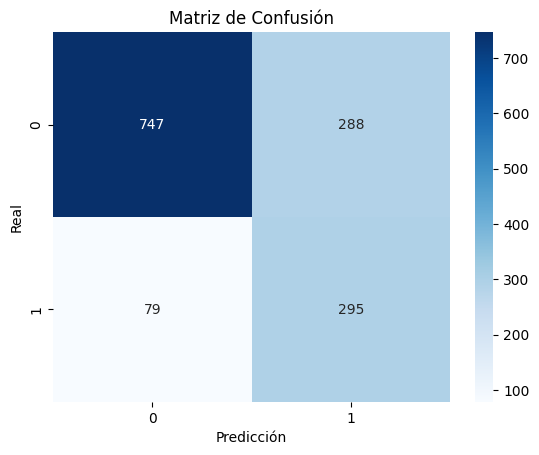

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🧪 Features y target
X = df.drop(columns=["Churn"])
y = df["Churn"]

# 🧹 Preprocesador
from src.telco_churn.features import build_preprocessor
preprocessor = build_preprocessor(X)

# 🔀 Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🧠 Modelo baseline
clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

clf.fit(X_train, y_train)

# 📊 Evaluación
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


Prueba Con RandomForest


In [24]:
from sklearn.ensemble import RandomForestClassifier
from src.telco_churn.train import train_and_log_model


rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42
)

train_and_log_model(
    df=df,  # Incluye la columna 'Churn'
    model=rf_model,
    model_name="RandomForest_baseline",
    experiment_name="telco_churn_experiment",
    
)



✅ Modelo 'RandomForest_baseline' entrenado y loggeado con MLflow.


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
